# Bandits (UCB & LinUCB)

_Ismaël Bonneau_ 

# Problème avec le regret (à régler quand j'aurais le tmps)

### But:

Ce TP a pour objectif d'expérimenter les modèles **UCB** et **LinUCB** vus en cours pour
de la sélection de publicité en ligne.

Un fichier de données pour la sélection de publicité en ligne a été préparé pour expérimenter les modèles. Ce fichier contient les
contextes (profils d'articles) et les taux de clic sur les publicités de 10 annonceurs pour
5000 articles (1 par ligne):
- <numero de l'article>:<représentation de l'article en 5 dimensions séparées par des ";">:<taux de
clics sur les publicités de 10 annonceurs séparés par des ";">

Pour chaque visite, l'objectif est de choisir la publicité d'un des 10 annonceurs permettant d'engrenger le plus fort taux de clics.

On modélise cette situation comme un problème de **bandit manchot** à 10 bras donc, un par annonceur.

On calculera pour chaque algorithme l'évolution du **regret** avec le nombre d'itérations.

<a href="http://dac.lip6.fr/master/rladl/">Site du module d'enseignement</a>

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()


datafile = "CTR.txt"

with open(datafile, "r") as f:
    tiascompris = f.readlines()
    features = np.zeros((len(tiascompris), 5))
    clics = np.zeros((len(tiascompris), 10))

    i = 0
    for line in tiascompris:
        features[i] = np.array([float(x) for x in line.strip().split(":")[1].split(";")])
        clics[i] = np.array([float(x) for x in line.strip().split(":")[2].split(";")])
        i += 1
        
assert clics.shape[0] == features.shape[0]

In [2]:
print(clics.shape, features.shape)

(5000, 10) (5000, 5)


#### Calcul du meilleur annonceur (meilleure moyenne) sur les 5000 articles

Ceci va servir au calcul du regret

In [3]:
best = np.argmax(np.mean(clics, axis=0))
mu_star = np.mean(clics, axis=0)[best]
print("Meilleur annonceur sur les 5000 articles:", best, ". mu:", mu_star)

Meilleur annonceur sur les 5000 articles: 3 . mu: 0.2679270062093166


In [4]:
def regret(n, rewards):
    return (mu_star * n) - np.sum(rewards)

## Baselines

Quelques baselines pour commencer

### Stratégie aléatoire

A chaque itération, on choisit un annonceur au hasard selon une loi uniforme.

In [5]:
epochs = 5000

#STRATEGIE ALEATOIRE

Q = np.zeros(clics.shape[1])
nmbredefoischoisie = np.zeros(clics.shape[1])
regrets = []

# Choisir chaque annonceur au moins 1 fois
for iteration in range(clics.shape[1]):
    Q[iteration] += clics[iteration][iteration]
    nmbredefoischoisie[iteration] += 1

for iteration in range(clics.shape[1], epochs):
    # tirer un annonceur de manière aléatoire
    a = np.random.randint(0,10)
    Q[a] += clics[iteration][a]
    nmbredefoischoisie[a] += 1
    
    reg = regret(iteration, Q)
    regrets.append(reg)

mu = np.argmax(Q / nmbredefoischoisie)

print("Meilleur annonceur: ", mu, "taux de clics estimé:", (Q / nmbredefoischoisie)[mu])

Meilleur annonceur:  3 taux de clics estimé: 0.26214459420865033


In [6]:
Q / nmbredefoischoisie

array([0.01609647, 0.08114577, 0.00663309, 0.26214459, 0.03444318,
       0.00302482, 0.10329609, 0.035665  , 0.0043406 , 0.24737197])

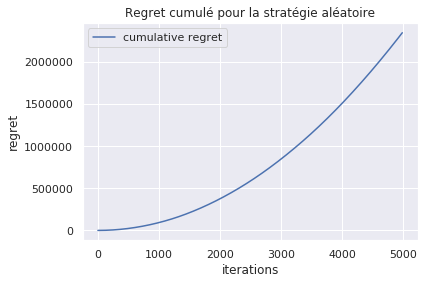

In [8]:
plt.title("Regret cumulé pour la stratégie aléatoire")
plt.xlabel("iterations")
plt.ylabel("regret")
plt.plot(range(epochs-clics.shape[1]), np.cumsum(np.array(regrets)), label="cumulative regret")
plt.legend()
plt.show()

### Stratégie static best:

A chaque itération, on choisit l'annonceur avec le meilleur taux de clics cumulé.

In [31]:
Q = np.zeros(clics.shape[1])
nmbredefoischoisie = np.zeros(clics.shape[1])
regrets = []

for iteration in range(clics.shape[1]):
    Q[iteration] += clics[iteration][iteration]
    nmbredefoischoisie[iteration] += 1

for iteration in range(clics.shape[1], epochs):

    #a = np.argmax(Q)
    a = np.argmax(np.sum(clics[:iteration+1], axis=0))
    
    Q[a] += clics[iteration][a]
    nmbredefoischoisie[a] += 1
    reg = regret(iteration, Q)
    regrets.append(reg)

mu = np.argmax(Q / nmbredefoischoisie)

print("Meilleur annonceur: ", mu, "taux de clics estimé:", (Q / nmbredefoischoisie)[mu])

Meilleur annonceur:  3 taux de clics estimé: 0.268175732048962


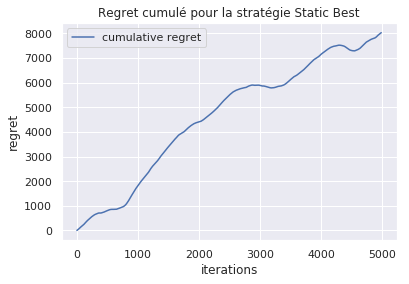

In [32]:
plt.title("Regret cumulé pour la stratégie Static Best")
plt.xlabel("iterations")
plt.ylabel("regret")
plt.plot(range(epochs-clics.shape[1]), np.cumsum(np.array(regrets)), label="cumulative regret")
plt.legend()
plt.show()

## Des stratégies plus intelligentes...

### Stratégie UCB

Choisir à chaque itération la meilleure variable qui n'a pas été assez explorée: ajoute un biais d'exploration dans l'algorithme. Permet théoriquement de bornet le regret de façon logarithmique.

In [43]:
rewards = np.zeros(clics.shape[1])
nmbredefoischoisie = np.zeros(clics.shape[1])
regrets = []

alpha = 2.

for iteration in range(clics.shape[1]):
    rewards[iteration] += clics[iteration][iteration]
    nmbredefoischoisie[iteration] += 1

for iteration in range(clics.shape[1], epochs):
    ucb = np.sqrt(alpha * np.log(iteration) / np.log(nmbredefoischoisie + 1))
    indices = values + ucb
    a = np.argmax(indices)

    rewards[a] += clics[iteration][a]
    nmbredefoischoisie[a] += 1
    nb = nmbredefoischoisie[a]
    values[a] = ((nb - 1) / float(nb)) * values[a] + (1 / float(nb)) * clics[iteration][a]
    
    reg = regret(iteration, rewards)
    regrets.append(reg)

mu = np.argmax(rewards / nmbredefoischoisie)

print("Meilleur annonceur: ", mu, "taux de clics estimé:", (Q / nmbredefoischoisie)[mu])

Meilleur annonceur:  3 taux de clics estimé: 0.27265991818727253


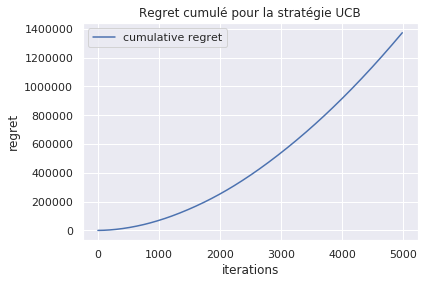

In [44]:
plt.title("Regret cumulé pour la stratégie UCB")
plt.xlabel("iterations")
plt.ylabel("regret")
plt.plot(range(epochs-clics.shape[1]), np.cumsum(np.array(regrets)), label="cumulative regret")
plt.legend()
plt.show()

### Stratégie LinUCB

Cet algorithme propose de prendre en compte le contexte de la décision, qui peut être très utile pour prévoir les variations des taux observés. On dispose justement des contextes de décision, chaque article étant représenté par un vecteur de features en 5 dimensions.

On a: 

- 5000 observations (articles)
- 5 features (descripteurs d'article)
- 10 bras (annonceurs)

In [53]:
rewards = np.zeros(clics.shape[1])
nmbredefoischoisie = np.zeros(clics.shape[1])
regrets = []

alpha = 2.

A = {} # contiendra les matrices A pour chaque arm
b = {} # contiendra les vecteurs b pour chaque arm

for iteration in range(epochs):
    # observer le contexte courant: (description de l'article)
    context = features[iteration]
    
    P = np.zeros(clics.shape[1])
    for arm in range(clics.shape[1]):
        # Si l'annonceur n'a pas encore été choisi:
        if nmbredefoischoisie[arm] == 0:
            A[arm] = np.identity(features.shape[1])
            b[arm] = np.zeros(features.shape[1])
        theta = np.linalg.inv(A[arm]).dot(b[arm]).reshape(-1, 1)
        tmp = np.sqrt(context.reshape(-1, 1).T @ np.linalg.inv(A[arm]) @ context.reshape(-1, 1)).squeeze()
        P[arm] = theta.T.dot(context.reshape(-1, 1)) + (alpha * tmp)
        
    # choisir le bras (annonceur) qui maximise P et observer le reward:
    a = np.argmax(P)
    reward = clics[iteration][a]
    
    rewards[a] += reward
    nmbredefoischoisie[a] += 1
    # mettre à jour A et b pour le bras choisi
    A[a] = A[a] + context.reshape(-1, 1) @ context.reshape(-1, 1).T
    b[a] = b[a] + (reward * context)
    
    reg = regret(iteration, rewards)
    regrets.append(reg)
    
mu = np.argmax(rewards / nmbredefoischoisie)

print("Meilleur annonceur: ", mu, "taux de clics estimé:", (rewards / nmbredefoischoisie)[mu])

Meilleur annonceur:  3 taux de clics estimé: 0.3328848236280366


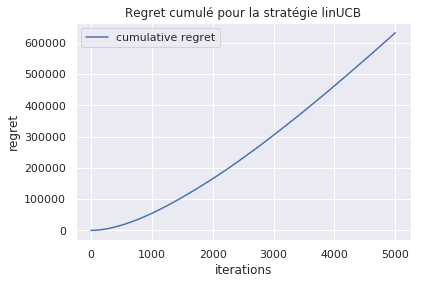

In [54]:
plt.title("Regret cumulé pour la stratégie linUCB")
plt.xlabel("iterations")
plt.ylabel("regret")
plt.plot(range(epochs), np.cumsum(regrets), label="cumulative regret")
plt.legend()
plt.show()